In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizerFast


In [4]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64",

In [5]:
from datasets import load_dataset

# Load SQuAD dataset
dataset = load_dataset("squad", split="train")

# Step 1: Add a new column for context length
dataset = dataset.map(lambda x: {"context_length": len(x["context"].split())})
dataset = dataset.map(lambda x: {"question_length": len(x["question"].split())})


# Step 2: Sort by the new column
sorted_dataset = dataset.sort("context_length")

# Step 3: Select the shortest 10k rows (or whatever range you need)
subset = sorted_dataset.select(range(11000))  # You can change this to 5000, 20000, etc.
df = subset.to_pandas()


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

In [6]:
# from datasets import load_dataset

# # Load SQuAD (only 5K samples for speed)
# dataset = load_dataset("squad", split="train[:11000]")

# # Convert to pandas
# df = dataset.to_pandas()


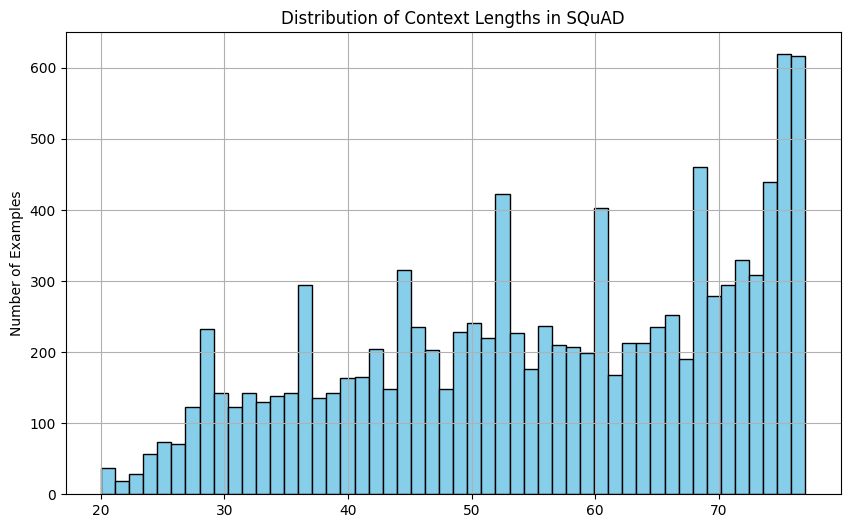

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: simulate context lengths (replace with your real lengths)
# Let's assume you already have a DataFrame df with 'context_length' column
# Here's a dummy setup to simulate it:
import numpy as np
# np.random.seed(42)
# df = pd.DataFrame({"context_length": np.random.gamma(shape=2, scale=100, size=11000).astype(int)})

# Plot histogram of context lengths
plt.figure(figsize=(10, 6))
plt.hist(df["context_length"], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Context Lengths in SQuAD")
plt.ylabel("Number of Examples")
plt.grid(True)
plt.show()


In [6]:
print("Max context length:", df["context_length"].max())
print("Max question length (in words):", df["question_length"].max())

max_context_len=df["context_length"].max()
max_question_len= df["question_length"].max()

Max context length: 77
Max question length (in words): 33


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Combine all context + question texts
all_texts = df['context'].tolist() + df['question'].tolist()

# Step 1: Fit the tokenizer (no num_words limit yet)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts)

# Step 2: Get actual vocab size
vocab_size = len(tokenizer.word_index)
print("Full vocab size:", vocab_size)

# Step 3: (optional) reinitialize with capped vocab
# Only if you want to restrict to top-k frequent words:
tokenizer = Tokenizer(num_words=vocab_size + 1, oov_token="<OOV>")
tokenizer.fit_on_texts(all_texts)


Full vocab size: 21643


In [19]:
vocab_size = len(tokenizer.word_index)
print("Vocabulary size (unique words):", vocab_size)


Vocabulary size (unique words): 21643


In [11]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def map_answer_char_to_token_index(context, answer_text, answer_start):
    # Tokenize the context using the same logic as text_to_word_sequence
    tokens = text_to_word_sequence(context)
    char_to_token_map = []
    running_offset = 0

    for token in tokens:
        token_start = context.lower().find(token, running_offset)
        token_end = token_start + len(token)
        char_to_token_map.append((token_start, token_end))
        running_offset = token_end

    answer_end = answer_start + len(answer_text)
    start_idx = None
    end_idx = None

    for i, (start_char, end_char) in enumerate(char_to_token_map):
        if start_idx is None and start_char <= answer_start < end_char:
            start_idx = i
        if start_char < answer_end <= end_char:
            end_idx = i

    # Fallback if end not found (e.g., single word)
    if start_idx is None:
        start_idx = np.argmin([abs(answer_start - s) for s, _ in char_to_token_map])

    if end_idx is None:
        end_idx = start_idx

    return start_idx, end_idx


In [10]:
# These are lists sliced from df[10000:11000]
full_context = df["context"].tolist()
full_questions = df["question"].tolist()
# answer_text = [a['text'][0] for a in df["answers"].tolist()]
# answer_start = [a['answer_start'][0] for a in df["answers"].tolist()]


**getting start and end tokens and y_start and y_end**

In [12]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

start_positions = []
end_positions = []

# Re-initialize
y_start = np.zeros((len(df), max_context_len))
y_end = np.zeros((len(df), max_context_len))

for idx, row in df.iterrows():
    context = row['context']
    answer_text = row['answers']['text'][0]
    answer_start = row['answers']['answer_start'][0]

    start_token, end_token = map_answer_char_to_token_index(context, answer_text, answer_start)

    start_positions.append(start_token)
    end_positions.append(end_token)

    if start_token < max_context_len:
        y_start[idx, start_token] = 1
    if end_token < max_context_len:
        y_end[idx, end_token] = 1


In [14]:
df['start_token'] = start_positions
df['end_token'] = end_positions



In [33]:
# These are lists sliced from df[10000:11000]
full_context = df["context"].tolist()
full_questions = df["question"].tolist()
# answer_text = [a['text'][0] for a in df["answers"].tolist()]
# answer_start = [a['answer_start'][0] for a in df["answers"].tolist()]


In [39]:
# import numpy as np

# # Re-initialize
# y_start = np.zeros((len(full_context), 300))
# y_end = np.zeros((len(full_context), 300))

# # Loop over test set and map character → token index correctly
# for i in range(len(full_context)):
#     # context = full_context[i]
#     # answer_text = answer_texts[i]
#     # answer_start = answer_starts[i]

#     # start_token, end_token = map_answer_char_to_token_index(context, answer_text, answer_start)

#     if start_token < 300:
#         y_start[i, start_token] = 1
#     if end_token < 300:
#         y_end[i, end_token] = 1


In [15]:
context_seqs = tokenizer.texts_to_sequences(df['context'].tolist())
question_seqs = tokenizer.texts_to_sequences(df['question'].tolist())


# last 1000 are test

In [16]:
from sklearn.model_selection import train_test_split

(
    context_train, context_test,
    question_train, question_test,
    y_start_train, y_start_test,
    y_end_train , y_end_test,
) = train_test_split(
    context_seqs, question_seqs, y_start, y_end,
    test_size=1000, random_state=42 ,shuffle =False
)

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max_context_len = max(len(seq) for seq in  context_seqs)
# print(max_context_len)
# max_question_len =  max(len(seq) for seq in  question_seqs)
# print(max_question_len)
# max_context_len = 300
# max_question_len = 30 
padded_contexts_train = pad_sequences(context_train, maxlen=max_context_len, padding='post', truncating='post')
padded_questions_train = pad_sequences(question_train, maxlen=max_question_len, padding='post', truncating='post')



In [18]:
padded_contexts_test = pad_sequences(context_test, maxlen=max_context_len, padding='post', truncating='post')
padded_questions_test = pad_sequences(question_test, maxlen=max_question_len, padding='post', truncating='post')

In [19]:
print("Context shape:", padded_contexts_train.shape)
print("Question shape:", padded_questions_train.shape)


Context shape: (10000, 77)
Question shape: (10000, 33)


In [20]:
print(np.argmax(y_start[18]))  # should match start_token of example 10001
print(np.argmax(y_end[18]))
print(start_positions[18])
print(end_positions[18])



9
13
9
13


In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate, RepeatVector
from tensorflow.keras.layers import TimeDistributed, Dropout
import tensorflow as tf
from tensorflow.keras.layers import Lambda


# Hyperparameters
embedding_dim = 256
hidden_size = 128
vocab_size = len(tokenizer.word_index) + 1  # from your tokenizer
# max_context_len = 300
# max_question_len = 30

# Inputs
context_input = Input(shape=(max_context_len,), name='context_input')
question_input = Input(shape=(max_question_len,), name='question_input')

# Embedding (you can load pretrained GloVe weights here)
embedding_layer = Embedding(input_dim=vocab_size+1, output_dim=embedding_dim, name='embedding')

# Embedded sequences
context_embed = embedding_layer(context_input)     # (batch, context_len, embed_dim)
question_embed = embedding_layer(question_input)   # (batch, question_len, embed_dim)


# Bi-LSTM encoding
context_encoded = Bidirectional(LSTM(hidden_size, return_sequences=True))(context_embed)
# question_encoded = Bidirectional(LSTM(hidden_size, return_sequences=False))(question_embed)

# Question representation = max pooled + dense
question_encoded = Bidirectional(LSTM(hidden_size, return_sequences=False))(question_embed)
# question_summary = Lambda(lambda x: tf.reduce_max(x, axis=1))(question_encoded)

# Optional: pass through a Dense layer
question_summary = Dense(hidden_size * 2, activation='tanh')(question_summary)





# Repeat
repeated_question = RepeatVector(max_context_len)(question_encoded)


# Repeat question vector across context time steps
# repeated_question = RepeatVector(max_context_len)(question_encoded)  # (batch, context_len, hidden*2)

# Concatenate context and question
# merged = Concatenate()([context_encoded, repeated_question])  # (batch, context_len, hidden*4)

merged = Concatenate()([
    context_encoded,
    repeated_question,
    tf.keras.layers.Subtract()([context_encoded, repeated_question]),
    tf.keras.layers.Multiply()([context_encoded, repeated_question])
])

# Optional: Dropout for regularization
merged = Dropout(0.3)(merged)
fused = Dense(128, activation='relu')(merged)
fused = Dropout(0.3)(fused)

# Output layers (start and end positions)
start_logits = TimeDistributed(Dense(1))(merged)  # (batch, context_len, 1)
start_logits = Lambda(lambda x: tf.squeeze(x, axis=-1))(start_logits)
start_probs = tf.keras.layers.Activation('softmax', name='start_output')(start_logits)

end_logits = TimeDistributed(Dense(1))(merged)
end_logits = Lambda(lambda x: tf.squeeze(x, axis=-1))(end_logits)
end_probs = tf.keras.layers.Activation('softmax', name='end_output')(end_logits)

# Final model
model = Model(inputs=[context_input, question_input], outputs=[start_probs, end_probs])
model.compile(
    optimizer='adam',
    loss={
        'start_output': 'categorical_crossentropy',
        'end_output': 'categorical_crossentropy'
    },
    metrics={
        'start_output': 'accuracy',
        'end_output': 'accuracy'
    }
)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ context_input             │ (None, 77)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ question_input            │ (None, 33)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 33, 256)        │      5,541,120 │ context_input[0][0],   │
│                           │                        │                │ question_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 256)            │        394,240 │ embedding[1][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 77, 256)        │        394,240 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_2           │ (None, 77, 256)        │              0 │ bidirectional_5[0][0]  │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_1 (Subtract)     │ (None, 77, 256)        │              0 │ bidirectional_4[0][0], │
│                           │                        │                │ repeat_vector_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 77, 256)        │              0 │ bidirectional_4[0][0], │
│                           │                        │                │ repeat_vector_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 77, 1024)       │              0 │ bidirectional_4[0][0], │
│ (Concatenate)             │                        │                │ repeat_vector_2[0][0], │
│                           │                        │                │ subtract_1[0][0],      │
│                           │                        │                │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 77, 1024)       │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 77, 1)          │          1,025 │ dropout_2[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 77, 1)          │          1,025 │ dropout_2[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 77)             │              0 │ time_distributed_2[0]… │
├──────────────────────

 Total params: 6,331,650 (24.15 MB)

 Trainable params: 6,331,650 (24.15 MB)

 Non-trainable params: 0 (0.00 B)

Start token index: 0
End token index: 72


In [12]:
print(df["question"][3])
print(df["context"][500])
print(df["answers"][3])


Where is The Oklahoma School of Science and Mathematics located?
Among the philosophies that have influenced modern architects and their approach to building design are rationalism, empiricism, structuralism, poststructuralism, and phenomenology.
{'text': array(['Oklahoma City'], dtype=object), 'answer_start': array([137], dtype=int32)}


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - end_output_accuracy: 0.0576 - end_output_loss: 3.7624 - loss: 7.6088 - start_output_accuracy: 0.0447 - start_output_loss: 3.8464 - val_end_output_accuracy: 0.1090 - val_end_output_loss: 3.2793 - val_loss: 6.7229 - val_start_output_accuracy: 0.0940 - val_start_output_loss: 3.4444
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - end_output_accuracy: 0.1683 - end_output_loss: 2.7645 - loss: 5.7818 - start_output_accuracy: 0.1548 - start_output_loss: 3.0173 - val_end_output_accuracy: 0.0690 - val_end_output_loss: 3.4846 - val_loss: 7.0517 - val_start_output_accuracy: 0.0740 - val_start_output_loss: 3.5633
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - end_output_accuracy: 0.2069 - end_output_loss: 2.3778 - loss: 4.9431 - start_output_accuracy: 0.2056 - start_output_loss: 2.5652 - val_end_output_accuracy: 0.0610 - val_end_output_loss: 3.9540 - val_loss: 7.9451 - val_start_output_accuracy: 0.0520 - val_start_output_loss:

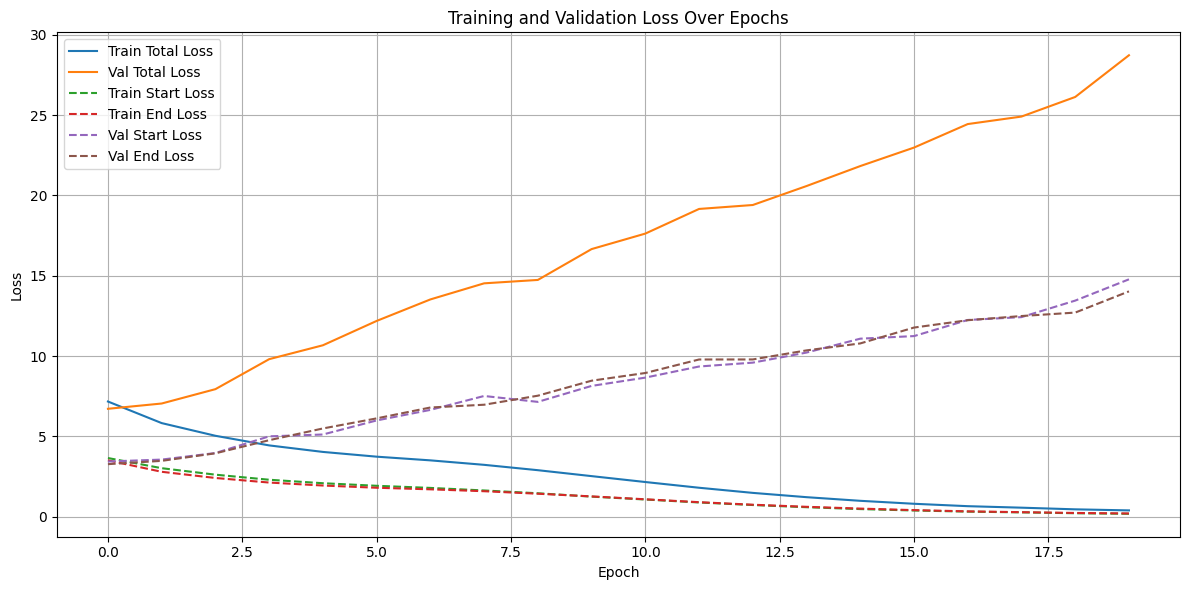

In [35]:
# # model.fit(
# #     [padded_contexts_train, padded_questions_train],   # inputs
# #     [y_start_train, y_end_train],                      # labels (two outputs)
# #     epochs=20,
# #     batch_size=32,
# #     validation_split=0.1,                  # optional: use 10% for validation
# #     verbose=1,
# #     shuffle=True  # 👈 THIS is the important line!

# # )


# from sklearn.utils import shuffle

# # Step 1: Shuffle ALL data before splitting
# X1_shuf, X2_shuf, y1_shuf, y2_shuf = shuffle(
#     padded_contexts_train, padded_questions_train, y_start_train, y_end_train, random_state=42
# )

# # Step 2: Manually split into train and val
# split_idx = int(len(X1_shuf) * 0.9)
# X1_train, X1_val = X1_shuf[:split_idx], X1_shuf[split_idx:]
# X2_train, X2_val = X2_shuf[:split_idx], X2_shuf[split_idx:]
# y1_train, y1_val = y1_shuf[:split_idx], y1_shuf[split_idx:]
# y2_train, y2_val = y2_shuf[:split_idx], y2_shuf[split_idx:]

# # Step 3: Train with manual validation
# model.fit(
#     [X1_train, X2_train],
#     [y1_train, y2_train],
#     validation_data=([X1_val, X2_val], [y1_val, y2_val]),
#     epochs=20,
#     batch_size=32,
#     shuffle=True,
#     verbose=1
# )



import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import History

# Simulated placeholders for demonstration; replace with actual data in real usage
# padded_contexts_train, padded_questions_train, y_start_train, y_end_train must be defined

# Step 1: Shuffle the data
X1_shuf, X2_shuf, y1_shuf, y2_shuf = shuffle(
    padded_contexts_train, padded_questions_train, y_start_train, y_end_train, random_state=42
)

# Step 2: Split into train and validation sets
split_idx = int(len(X1_shuf) * 0.9)
X1_train, X1_val = X1_shuf[:split_idx], X1_shuf[split_idx:]
X2_train, X2_val = X2_shuf[:split_idx], X2_shuf[split_idx:]
y1_train, y1_val = y1_shuf[:split_idx], y1_shuf[split_idx:]
y2_train, y2_val = y2_shuf[:split_idx], y2_shuf[split_idx:]

# Step 3: Train the model
history = model.fit(
    [X1_train, X2_train],
    [y1_train, y2_train],
    validation_data=([X1_val, X2_val], [y1_val, y2_val]),
    epochs=20,
    batch_size=32,
    shuffle=True,
    verbose=1
)

# Step 4: Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.plot(history.history['start_output_loss'], label='Train Start Loss', linestyle='--')
plt.plot(history.history['end_output_loss'], label='Train End Loss', linestyle='--')
plt.plot(history.history['val_start_output_loss'], label='Val Start Loss', linestyle='--')
plt.plot(history.history['val_end_output_loss'], label='Val End Loss', linestyle='--')
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
from sklearn.utils import shuffle
import numpy as np

indices = np.arange(len(padded_contexts_test))  # [0, 1, 2, ..., 999]
(
    padded_contexts_test_shuf,
    padded_questions_test_shuf,
    y_start_test_shuf,
    y_end_test_shuf,
    indices_shuf
) = shuffle(
    padded_contexts_test,
    padded_questions_test,
    y_start_test,
    y_end_test,
    indices,
    random_state=42
)


In [37]:
start_preds, end_preds = model.predict([padded_contexts_test_shuf, padded_questions_test_shuf])

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step


# 2 methods to prevent end token to be before start token after prediction
  1 using multiplicaiton
  2 using addition

In [171]:
import numpy as np

def get_best_span(start_probs, end_probs, max_answer_len=):
    max_score = -np.inf
    best_start, best_end = 0, 0
    log_start = np.log(start_probs + 1e-9)
    log_end = np.log(end_probs + 1e-9)
    
    for i in range(len(start_probs)):
        for j in range(i, min(i + max_answer_len, len(end_probs))):
            score = log_start[i] + log_end[j]  # log of joint prob
            if score > max_score:
                max_score = score
                best_start, best_end = i, j
    return best_start, best_end


In [114]:
# ✅ Function to get best span from predicted probabilities
def get_best_span(start_probs, end_probs, max_answer_len=7):
    max_prob = 0
    best_start, best_end = 0, 0
    for i in range(len(start_probs)):
        # Only consider end positions that are >= start and within max length
        for j in range(i, min(i + max_answer_len, len(end_probs))):
            prob = start_probs[i] * end_probs[j]
            if prob > max_prob:
                max_prob = prob
                best_start, best_end = i, j
    return best_start, best_end


In [115]:
# ⛳ Replace argmax() with best span logic
pred_start_indices = []
pred_end_indices = []

for i in range(len(start_preds)):
    s, e = get_best_span(start_preds[i], end_preds[i], max_answer_len=15)
    pred_start_indices.append(s)
    pred_end_indices.append(e)


In [38]:
pred_start_indices = np.argmax(start_preds, axis=1)
pred_end_indices = np.argmax(end_preds, axis=1)

true_start_indices = np.argmax(y_start_test_shuf, axis=1)
true_end_indices = np.argmax(y_end_test_shuf, axis=1)

start_acc = np.mean(pred_start_indices == true_start_indices)
end_acc = np.mean(pred_end_indices == true_end_indices)

exact_match = np.mean((pred_start_indices == true_start_indices) & (pred_end_indices == true_end_indices))

print(f"Start Accuracy: {start_acc:.2%}")
print(f"End Accuracy: {end_acc:.2%}")
print(f"Exact Match: {exact_match:.2%}")

Start Accuracy: 9.40%
End Accuracy: 8.50%
Exact Match: 4.30%


In [39]:
pred_end_indices -pred_start_indices 


array([ 13,   0,   3,  19,  25,  59, -37,   0,   0,   4,   3,   6,   2,
        10,   1, -60,  61,   1,  22,   1,   0, -22, -42, -22,   3,  10,
         1, -18,   1,   2,   0,  18,   0, -67,  29,   0,   3,   2,  23,
         1,  41,   0, -44,   2,  54,   1,  -3,   6,   8,  22,  24, -41,
       -11,   1, -67,   0,   5,  14,   2,   2, -15,   0,  67,   2,   0,
        46,  19,  33, -18,  41,   2,   9,   1,   2,  24, -25,   0,  -8,
         0, -15,   0,   1, -24,   2,  72,   0,  67,   2,   2,   9,  -1,
       -26,   1,  31,   1,   0,  30,   1,  -4, -67, -21,   0,   1,  11,
         2,   7,   4,   0,  -7,   0, -30, -67, -26,  22,   6,  19,   2,
       -17, -22,  24,   0, -16,   0, -15,   5,  24,  34,  10, -28,   3,
        12,  38,   0, -12,   2,   1,   3, -35,   0,   0,   4,  -3,   2,
         0,   0,   0,  67,  54, -19,  68,   0,   0, -17,  -4,   4,   0,
       -20,  -1,  61,   1,   7,  43,  -4,  15,   2,   1,   0,   0, -33,
       -41,  46,   1,   0, -26,  -5, -16,   0,  11, -10, -71,   

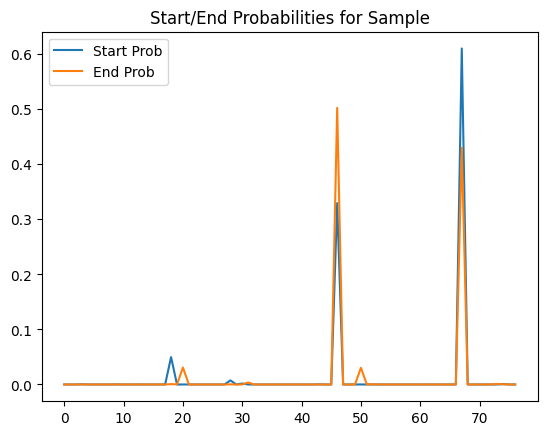

In [40]:
import matplotlib.pyplot as plt

i = 100 # change to the index of a sample with repeating span

plt.plot(start_preds[i], label='Start Prob')
plt.plot(end_preds[i], label='End Prob')
plt.legend()
plt.title("Start/End Probabilities for Sample")
plt.show()


[67,
 67,
 40,
 40,
 40,
 40,
 78,
 78,
 78,
 26,
 26,
 13,
 13,
 13,
 65,
 65,
 9,
 9,
 38,
 38,
 21,
 21,
 21,
 21,
 21,
 16,
 16,
 16,
 48,
 48,
 48,
 71,
 71,
 71,
 71,
 43,
 43,
 43,
 43,
 0,
 0,
 0,
 26,
 26,
 26,
 31,
 31,
 31,
 31,
 26,
 26,
 26,
 1,
 1,
 1,
 1,
 7,
 7,
 20,
 20,
 20,
 39,
 39,
 6,
 6,
 6,
 59,
 59,
 59,
 59,
 10,
 10,
 54,
 54,
 54,
 54,
 53,
 53,
 53,
 13,
 13,
 13,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 23,
 43,
 43,
 43,
 43,
 3,
 3,
 3,
 17,
 17,
 80,
 80,
 80,
 14,
 14,
 53,
 53,
 53,
 53,
 38,
 38,
 38,
 38,
 38,
 36,
 36,
 36,
 36,
 36,
 16,
 16,
 16,
 7,
 7,
 7,
 36,
 36,
 36,
 36,
 36,
 36,
 22,
 22,
 22,
 6,
 6,
 6,
 61,
 61,
 61,
 61,
 61,
 44,
 44,
 44,
 8,
 8,
 23,
 23,
 23,
 0,
 0,
 23,
 23,
 23,
 51,
 51,
 51,
 51,
 15,
 15,
 15,
 15,
 18,
 18,
 18,
 2,
 2,
 51,
 51,
 51,
 38,
 4,
 4,
 4,
 70,
 70,
 70,
 70,
 70,
 70,
 43,
 43,
 43,
 20,
 20,
 41,
 41,
 41,
 41,
 10,
 10,
 10,
 5,
 5,
 1,
 41,
 41,
 41,
 64,
 64,
 64,
 17,
 17,
 17,
 0,
 0,
 29,
 29,
 29,

**Failed Attempt**

In [41]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

for i in range(1000):
    tokens = text_to_word_sequence(contexts[i])

    pred_ans = ' '.join(tokens[pred_start_indices[i]:pred_end_indices[i]+1])
    true_ans = ' '.join(tokens[true_start_indices[i]:true_end_indices[i]+1])
    raw_ans = answer_texts[i]

    print(f"Q: {questions[i]}")
    print(f"Predicted: {pred_ans}")
    print(f"Token-Mapped True: {true_ans}")
    print(f"Raw Answer from Dataset: {raw_ans}")
    print('-' * 50)

NameError: name 'contexts' is not defined

In [116]:
example = df.iloc[10005]
question = example["question"]
context = example["context"]
answer_text = example["answers"]["text"][0]
answer_start = example["answers"]["answer_start"][0]
print(context)
print(answer_text)

start_token, end_token = map_answer_char_to_token_index(context, answer_text, answer_start)

print("Start token index:", start_token)
print("End token index:", end_token)
print( np.argmax(y_end[10005],axis=0))
print(np.argmax(y_start[10005],axis=0))


Polytechnics were tertiary education teaching institutions in England, Wales and Northern Ireland. Since 1970 UK Polytechnics operated under the binary system of education along with universities. Polytechnics offered diplomas and degrees (bachelor's, master's, PhD) validated at the national level by the UK Council for National Academic Awards CNAA. They particularly excelled in engineering and applied science degree courses similar to technological universities in the USA and continental Europe. The comparable institutions in Scotland were collectively referred to as Central Institutions. Britain's first Polytechnic, the Royal Polytechnic Institution later known as the Polytechnic of Central London (now the University of Westminster) was established in 1838 at Regent Street in London and its goal was to educate and popularize engineering and scientific knowledge and inventions in Victorian Britain "at little expense." The London Polytechnic led a mass movement to create numerous Polyt

In [90]:
# These are lists sliced from df[10000:11000]
contexts = df["context"].iloc[10000:11000].tolist()
questions = df["question"].iloc[10000:11000].tolist()
answer_texts = [a['text'][0] for a in df["answers"].iloc[10000:11000].tolist()]
answer_starts = [a['answer_start'][0] for a in df["answers"].iloc[10000:11000].tolist()]


In [42]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

for local_i in range(10):  # loop over 1000 test examples
    tokens = text_to_word_sequence(contexts[local_i])

    # Extract predicted and true token indices
    pred_start = pred_start_indices[local_i]
    pred_end = pred_end_indices[local_i]
    true_start = true_start_indices[local_i]
    true_end = true_end_indices[local_i]

    # Avoid index out of bounds
    if pred_start >= len(tokens) or pred_end >= len(tokens):
        pred_ans = "[predicted index out of range]"
    else:
        pred_ans = ' '.join(tokens[pred_start:pred_end + 1])

    if true_start >= len(tokens) or true_end >= len(tokens):
        true_ans = "[true index out of range]"
    else:
        true_ans = ' '.join(tokens[true_start:true_end + 1])

    # Raw answer using character span
    start_char = answer_starts[local_i]
    raw_ans = contexts[local_i][start_char:start_char + len(answer_texts[local_i])]

    # Print everything
    print(f"🟦 Example #{local_i + 1}")
    print(f"❓ Question: {questions[local_i]}")
    print(f"📘 Context: {contexts[local_i]}")
    print(f"✅ Raw Answer (char-based): {raw_ans}")
    print(f"🎯 True Answer (token-based): {true_ans}")
    print(f"🤖 Predicted Answer: {pred_ans}")
    
    if pred_ans == true_ans:
        print("✅ MATCH")
    else:
        print("❌ MISMATCH")
    print("-" * 100)


NameError: name 'contexts' is not defined

In [41]:
# Choose a sample index from the test range
# local_i = 800  # 0–999 within the test set
df_index = 10000 

# Extract raw context, question, and answer from the DataFrame
for local_i in range(50):  # loop over 1000 test examples
    context = df.loc[df_index + local_i, 'context']
    question = df.loc[df_index + local_i, 'question']
    answer_text = df.loc[df_index + local_i, 'answers']['text'][0]
    answer_start_char = df.loc[df_index + local_i, 'answers']['answer_start'][0]

# Tokenize the context
    tokens = text_to_word_sequence(context)

# You must already have y_start and y_end (token-based index lists) for alignment
    true_start = np.argmax(y_start_test[local_i])
    true_end = np.argmax(y_end_test[local_i])
    start =pred_start_indices[local_i]
    end = pred_end_indices[local_i]
# Extract the answer span from tokens
    token_answer = ' '.join(tokens[true_start:true_end + 1])
    predicted=' '.join(tokens[start:end + 1])



# Extract raw text answer from context using char span
    raw_answer_from_context = context[answer_start_char:answer_start_char + len(answer_text)]


# Display everything
    print(f"🔎 Sample #{local_i} (df index: {df_index})")
    print(f"❓ Question: {question}")
    print(f"📘 Context: {context}")
    print(f"✅ True Answer (from raw char span): {raw_answer_from_context}")
    print(f"🎯 Token Answer (from y_start/y_end): {token_answer}")
    # print(f"🔢 y_start = {true_start}, y_end = {true_end}")
    print(f"🔢 prediction  = {predicted}")
    print("------------------------------------------------------------------------------------------------")



🔎 Sample #0 (df index: 10000)
❓ Question: The instruments used to point out the different corrupt forms looked to see if they were rigidly domestic or what?
📘 Context: The purpose of these instruments was to address the various forms of corruption (involving the public sector, the private sector, the financing of political activities, etc.) whether they had a strictly domestic or also a transnational dimension. To monitor the implementation at national level of the requirements and principles provided in those texts, a monitoring mechanism – the Group of States Against Corruption (also known as GRECO) (French: Groupe d'Etats contre la corruption) was created.
✅ True Answer (from raw char span): transnational
🎯 Token Answer (from y_start/y_end): transnational
🔢 prediction  = financing of political activities etc whether they had a strictly domestic or also a
------------------------------------------------------------------------------------------------
🔎 Sample #1 (df index: 10000)
❓ Q

In [42]:
# Loop over shuffled test set (first 50 samples as an example)
for local_i in range(50):
    original_index = indices_shuf[local_i]  # map back to original df row
    df_index = 10000 + original_index       # adjust to match full DataFrame index

    context = df.loc[df_index, 'context']
    question = df.loc[df_index, 'question']
    answer_text = df.loc[df_index, 'answers']['text'][0]
    answer_start_char = df.loc[df_index, 'answers']['answer_start'][0]

    # Tokenize context using Keras logic
    tokens = text_to_word_sequence(context)

    # From y_true
    true_start = np.argmax(y_start_test_shuf[local_i])
    true_end = np.argmax(y_end_test_shuf[local_i])

    # From model predictions
    pred_start = pred_start_indices[local_i]
    pred_end = pred_end_indices[local_i]

    # Get answer text spans
    token_answer = ' '.join(tokens[true_start:true_end + 1])
    predicted = ' '.join(tokens[pred_start:pred_end + 1])
    raw_answer_from_context = context[answer_start_char:answer_start_char + len(answer_text)]

    # Display
    print(f"🔎 Sample #{local_i} (df index: {df_index})")
    print(f"❓ Question: {question}")
    print(f"📘 Context: {context}")
    print(f"✅ True Answer (from raw char span): {raw_answer_from_context}")
    print(f"🎯 Token Answer (from y_start/y_end): {token_answer}")
    print(f"🔢 prediction  = {predicted}")
    print("------------------------------------------------------------------------------------------------")


🔎 Sample #0 (df index: 10521)
❓ Question: What genre of music is not played frequently on urban AC?
📘 Context: The urban AC stations resemble soft AC rather than hot AC; they play predominantly R&B and soul music with little hip-hop. This is reflected in many of the urban AC radio stations' taglines, such as "Today's R&B and classic soul", "The best variety of R&B hits and oldies" and "(City/Region)'s R&B leader". Urban AC's core artists include Luther Vandross, Trey Songz, Patti LaBelle, Toni Braxton, Whitney Houston, Aretha Franklin, Frank Ocean, Craig David and Mariah Carey.
✅ True Answer (from raw char span): hip-hop
🎯 Token Answer (from y_start/y_end): hip hop
🔢 prediction  = hip hop this is reflected in many of the urban ac radio stations' taglines
------------------------------------------------------------------------------------------------
🔎 Sample #1 (df index: 10737)
❓ Question: From what chronic illness was Nasser suffering?
📘 Context: In early 1962 Nasser again attempted 

In [31]:
# Loop over original test order (0 to 999)
for original_i in range(50,100):  # or 1000 for full test set
    # Find its position in the shuffled data
    local_i = np.where(indices_shuf == original_i)[0][0]  # where original_i ended up

    df_index = 10000 + original_i  # index in full DataFrame

    context = df.loc[df_index, 'context']
    question = df.loc[df_index, 'question']
    answer_text = df.loc[df_index, 'answers']['text'][0]
    answer_start_char = df.loc[df_index, 'answers']['answer_start'][0]

    # Tokenize context using Keras logic
    tokens = text_to_word_sequence(context)

    # Ground truth (from shuffled test labels)
    true_start = np.argmax(y_start_test_shuf[local_i])
    true_end = np.argmax(y_end_test_shuf[local_i])

    # Predictions (from shuffled model outputs)
    pred_start = pred_start_indices[local_i]
    pred_end = pred_end_indices[local_i]

    # Get token span answers
    token_answer = ' '.join(tokens[true_start:true_end + 1])
    predicted = ' '.join(tokens[pred_start:pred_end + 1])
    raw_answer_from_context = context[answer_start_char:answer_start_char + len(answer_text)]

    # Display
    print(f"🔎 Sample #{original_i} (df index: {df_index})")
    print(f"❓ Question: {question}")
    print(f"📘 Context: {context}")
    print(f"✅ True Answer (from raw char span): {raw_answer_from_context}")
    print(f"🎯 Token Answer (from y_start/y_end): {token_answer}")
    print(f"🔢 prediction  = {predicted}")
    print("------------------------------------------------------------------------------------------------")


🔎 Sample #50 (df index: 10050)
❓ Question: The superior colliculus is related to what sensual control of vertebrates?
📘 Context: The elaboration of the cerebral cortex carries with it changes to other brain areas. The superior colliculus, which plays a major role in visual control of behavior in most vertebrates, shrinks to a small size in mammals, and many of its functions are taken over by visual areas of the cerebral cortex. The cerebellum of mammals contains a large portion (the neocerebellum) dedicated to supporting the cerebral cortex, which has no counterpart in other vertebrates.
✅ True Answer (from raw char span): visual
🎯 Token Answer (from y_start/y_end): visual
🔢 prediction  = 
------------------------------------------------------------------------------------------------
🔎 Sample #51 (df index: 10051)
❓ Question: The larger part of the cerebellum in mammals is called what?
📘 Context: The elaboration of the cerebral cortex carries with it changes to other brain areas. The 

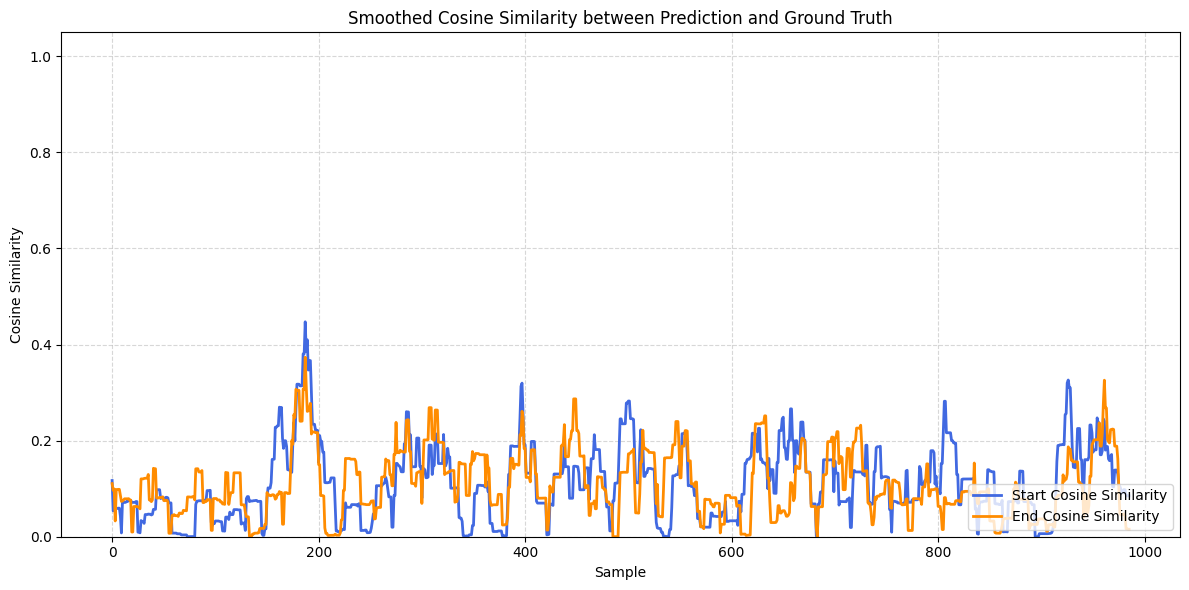

In [45]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Example over test set
start_cos_sim = []
end_cos_sim = []

for i in range(len(y_start_test)):
    start_cos = cosine_similarity([start_preds[i]], [y_start_test_shuf[i]])[0][0]
    end_cos = cosine_similarity([end_preds[i]], [y_end_test_shuf[i]])[0][0]

    start_cos_sim.append(start_cos)
    end_cos_sim.append(end_cos)

# Smoothing using moving average for cleaner visualization
def smooth(values, window=10):
    return np.convolve(values, np.ones(window)/window, mode='valid')

smooth_start = smooth(start_cos_sim, window=15)
smooth_end = smooth(end_cos_sim, window=15)
x_vals = np.arange(len(smooth_start))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(x_vals, smooth_start, label='Start Cosine Similarity', color='royalblue', linewidth=2)
plt.plot(x_vals, smooth_end, label='End Cosine Similarity', color='darkorange', linewidth=2)
plt.title("Smoothed Cosine Similarity between Prediction and Ground Truth")
plt.xlabel("Sample")
plt.ylabel("Cosine Similarity")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

